In [1]:
import os
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
f = h5py.File("hubbard_exact.h5", "r")

In [3]:
exact_energy = np.min(f["energies"]).real
print(f"Ground state energy from FCI = {exact_energy}")

Ground state energy from FCI = -1.2360679774997896


In [4]:
listing = os.listdir("data/")
results_files = [f for f in listing if "hubbard_eigvals_" in f]
print(results_files)

['hubbard_eigvals_20_steps.h5', 'hubbard_eigvals_30_steps.h5', 'hubbard_eigvals_50_steps.h5', 'hubbard_eigvals_100_steps.h5', 'hubbard_eigvals_10_steps.h5', 'hubbard_eigvals_1_steps.h5']


In [5]:
dfs = []
for f in results_files:
    df = pd.read_hdf("data/" + f, key="eigenvalues")
    h5_file = h5py.File("data/" + f)
    tau = h5_file["tau"][()]
    steps = h5_file["steps"][()]
    h5_file.close()
    df["tau"] = tau
    df["steps"] = steps
    dfs.append(df)

In [6]:
big_df = pd.concat(dfs)
big_df["rel_error"] = abs(big_df["energy"] - exact_energy) / abs(exact_energy)
print(big_df.head())

   d           eps    energy   tau  steps  rel_error
i                                                   
0  3  1.000000e-12 -1.236024  0.05     20   0.000036
1  3  2.154435e-10 -1.236024  0.05     20   0.000036
2  3  4.641589e-08 -1.236024  0.05     20   0.000036
3  3  1.000000e-05 -1.236024  0.05     20   0.000036
4  4  1.000000e-12 -1.236024  0.05     20   0.000036


In [7]:
df_max_d = big_df[big_df["d"] == max(df["d"])]

In [8]:
# Get row with the lowest relative error.
big_df[big_df['rel_error'] == big_df['rel_error'].min()]

,d,eps,energy,tau,steps,rel_error
i,,,,,,
52,16,1.000000e-12,-1.236066,0.05,100,0.000001
53,16,2.154435e-10,-1.236066,0.05,100,0.000001
54,16,4.641589e-08,-1.236066,0.05,100,0.000001
55,16,1.000000e-05,-1.236066,0.05,100,0.000001


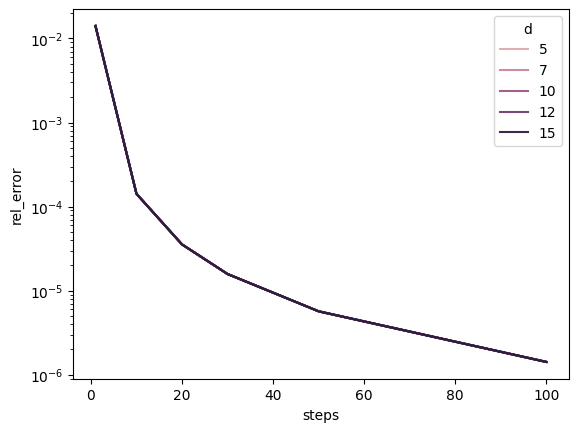

In [9]:
fig, ax = plt.subplots()
sns.lineplot(data=big_df, x="steps", y="rel_error", hue="d")
ax.set_yscale("log")
#plt.show()
plt.savefig("hubbard_error.pdf")